# Second Assignment of RTII course

## User Interface node

In this Jupyter notebook I have implemented an user interface useful to control the behavior of a robot, within  a simulated environment. Moreover the  node communicates with three different nodes:

1. nodes go_to_point.py 
2. state_machine.cpp 
3. position_service.cpp 

They all are available within the **action** branch belonging to the package rt2_assignment1 
Inside this notebook, different widgets and visualization methods have been employed to directly interact  with the robot simulation launched within Gazebo.


## How to run the code

Within a new shell, please type:

roslaunch rt2_assignment1 jupisim.launch

Then open this jupiter notebook by running:

jupyter notebook --allow-root --ip 0.0.0.0




Here Below, needed headers are imported and global variables are initialized 

In [1]:

from ipywidgets import Button, Layout, ButtonStyle, GridBox, VBox, HBox
import numpy as np
import matplotlib.pyplot as plt
import jupyros as jr
import rospy
import time
import math
from rt2_assignment1.srv import Command
import actionlib
import rt2_assignment1.msg
from geometry_msgs.msg import Twist
from matplotlib import animation, rc
import ipywidgets as widgets
from IPython.display import display
from matplotlib import animation, rc
from matplotlib.animation import FuncAnimation
from nav_msgs.msg import Odometry
from rt2_assignment1.msg import GoalReachingActionResult
%matplotlib widget

# initializing the node 
rospy.init_node('user_interface')
# user_interface client for starting the  "go to point behaviour"
ui_client = rospy.ServiceProxy('/user_interface', Command)
# action client to cancel the action goal
client = actionlib.SimpleActionClient('go_to_point', rt2_assignment1.msg.GoalReachingAction)
# declaring a publisher of /cmd_vel topic for controlling the robot's velocity
pub=rospy.Publisher('/cmd_vel', Twist, queue_size=1)
time.sleep(10)

# global variables initialization

cancelled=0   # variable useful for counting the cancelled targets
reached=0     # variable useful for counting the reached targets
active=False  # boolean variable for checking the activation/deactivation status of the go_to_point behavior
start_time=0  # variable for keeping track of the moment within which the robot starts reaching a goal 
stop_time=0   # variable for keeping track of the moment within which the robot stops reaching a goal
data = list() # variable for plotting the histogram 

# Further global variables initialization 

clock = time.time()             # time offset
time_plot = list(range(0, 10))  # variable useful for plotting the time coordinates 
odom_linear =list()             # variable for plotting the linear velocity retrieved by the /odom topic
cmdvel_linear=list()            # variable for plotting the linear velocity retrieved by the /cmd_vel topic

# 

odom_angular =list()            # variable for plotting the angular velocity retrieved by the /odom topic
cmdvel_angular=list()           # variable for plotting the angular velocity retrieved by the /cmd_vel topic

# 

x_data=list()                   # variable for plotting the x coordinate retrieved by the /odom topic 
y_data=list()                   # variable for plotting the y coordinate retrieved by the /odom topic

# Variables for storing the orientation

dx=0
dy=1

ImportError: cannot import name 'GoalReachingActionResult' from 'rt2_assignment1.msg' (/root/my_ros_ws/devel/lib/python3/dist-packages/rt2_assignment1/msg/__init__.py)

## The goal reaching behavior 

The ```go_to_point``` behavior can be directly activated and deactivated by the user. He/she has just to click on the **START** or **STOP** button. Indeed, according to the```on_click``` method, each time a button is clicked, the clbk gets executed. 
Actually, this is the reason why the service client is called inside the callback of the **START** button. Otherwise, inside the callback of the **STOP** button, the robot is at first stopped, publishing a zero velocity on ```/cmd_vel```. Then, the action client is called so that all the goals could be cancelled

In [2]:

button_start = widgets.Button(description="START",layout=widgets.Layout(widht='auto',grid_area='b1'),
                style=widgets.ButtonStyle(button_color='green') )

button_stop = widgets.Button(description="STOP",  layout=widgets.Layout(width='auto', grid_area='b2'),
                    style=widgets.ButtonStyle(button_color='red'))



def clicked_start(b): 
     global start_time
     global active
     global count
     #call the service client
     ui_client("start")      
     active=True
     take=False
     start_time=time.time()
     
     
        
def clicked_stop(b):
     global cancelled
     global stop_time
     global active
     global data
     # call the action client
     client.cancel_all_goals()
     twist_msg = Twist()
     twist_msg.linear.x = 0
     twist_msg.linear.y = 0
     twist_msg.angular.z = 0
     # publish a zero velocity
     pub.publish(twist_msg)
     ui_client("stop")
     if active==True:
         cancelled = cancelled + 1 
         active=False
         stop_time=time.time()
         data.append(stop_time-start_time)
 
# on click method

button_start.on_click(clicked_start)
button_stop.on_click(clicked_stop)

In [3]:
# GridBox is used for displaying buttons 
widgets.GridBox(children=[button_start,button_stop],
                layout=widgets.Layout(width='80%',grid_template_rows='auto auto auto',
                grid_template_columns='16% 16% 16% 16% 16% 16% ',
                grid_template_areas='''"b1 b2 . . . "''')
               )

GridBox(children=(Button(description='START', layout=Layout(grid_area='b1'), style=ButtonStyle(button_color='g…

# Employed Callbacks 

## `reached_goal_clb` callback

This latter, belonging to the ```/go_to_point/result``` topic, gets executed only once a goal is reached. 
Then, some variables meant at visualization purposes, get updated

In [4]:
def reached_goal_clb(msg):
    """
    reached_goal_clb function
    
    Here, some variables have been initialized  for
    knowing the starting and the ending instants of 
    the robot movement during the achievement of a
    certain goal. Moreover, an array (data) has been
    introduced for storing the amount of time spent
    for reaching it. Indeed, every time a newer goal 
    gets reached, the difference between the starting 
    and the ending istants, is added to the array

   """
    global reached
    global start_time,stop_time
    global data 
    stop_time=time.time()
    data.append(stop_time-start_time)
    start_time=time.time()
    reached = reached+1
  

jr.subscribe('/go_to_point/result',GoalReachingActionResult, reached_goal_clb)

NameError: name 'GoalReachingActionResult' is not defined

## `clb_odom` callback

This is the /odom callback, employed for getting back values about: 
* **The x and y coordinates** of the robot position: for updating the position array 
* The **linear and angular velocity** along **x** and around **z**, respectively: for updating the arrays aimed at representing the linear and angular plots
* **The quaternion**: for computing the orientation values 
Once the yaw has been computed by the `euler_from_quaternion` function, it gets normailzed in a value included between -$\pi$ and +$\pi$. To conclude with, `dx`and `dy`variables, have been stored with the cosine and sine  of the normalized yaw value.

In [5]:
def normalize_angle(angle):
    '''
    Function aimed at transforming an angle within a specified
    interval of values (-pi,pi)
    
    '''
    if(math.fabs(angle) > math.pi):
        angle = angle - (2 * math.pi * angle) / (math.fabs(angle))
    return angle

def euler_from_quaternion(x, y, z, w):
    '''
    Function aimed at converting a quaternion into euler angles 
    (roll, pitch and yaw). 
    
    '''
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    roll_x = math.atan2(t0, t1)
     
    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    pitch_y = math.asin(t2)
     
    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    yaw_z = math.atan2(t3, t4)
     
    return roll_x, pitch_y, yaw_z 



def clb_odom(msg):
    '''
    Callback function for the /odom topic
    '''
    global time_plot, odom_linear, odom_angular
    global x_data, y_data
    global dx, dy
    
    if len(time_plot)>10:                       # controlling the plot time_plot size
      time_plot.pop(0)
     
    if len(odom_linear)>10:                     # controlling the odom_linear size 
      odom_linear.pop(0)
    
    y_1 = np.float32(msg.twist.twist.linear.x)  # retrieve the linear velocity
    x_1 = np.float32(time.time()-clock)         # updating the timeline     
    
    # Updating arrays
    
    odom_linear.append(y_1)                     
    time_plot.append(x_1)
     
    if len(odom_angular)>10:
      odom_angular.pop(0)
    y_2 = np.float32(msg.twist.twist.angular.z)  # rertrieve the angular velocity
    odom_angular.append(y_2)
    
    
    if len(x_data)>50:                           # controlling the x_data size 
      x_data.pop(0)
      
    if len(y_data)>50:                           # controlling the y_data size 
      y_data.pop(0)
    
    # Retrieving position values
    
    y_3 = np.float32(msg.pose.pose.position.y)
    x_3 = np.float32(msg.pose.pose.position.x)
    y_data.append(y_3)
    x_data.append(x_3)
    
    # quaternion initialization
    
    quaternion = (
        msg.pose.pose.orientation.x,
        msg.pose.pose.orientation.y,
        msg.pose.pose.orientation.z,
        msg.pose.pose.orientation.w)
    
    # filling euler variable with Euler angles 
    euler = euler_from_quaternion(quaternion[0],quaternion[1],quaternion[2],quaternion[3])
    
    # getting the yaw value (the one we are interested in)
    yaw_ = euler[2]
    
    # yaw angle normalization
    normalized_yaw=normalize_angle(yaw_)
    
    # x and y yaw components for representing orientation
    dx=math.cos(normalized_yaw)
    dy=math.sin(normalized_yaw)
    
# odom clbk
jr.subscribe('/odom',Odometry, clb_odom)

## `clb_cmdvel` callback

Within this callback, newer linear and angular velocities' values are employed to update arrays whose size is limited to 10. This has been necessary for plotting purposes.

In [6]:
def clb_cmdvel(msg):
    global cmdvel_linear, cmdvel_angular
    if len(cmdvel_linear)>10:       # controlling the array size
      cmdvel_linear.pop(0)
    y_4 = np.float32(msg.linear.x)  # get value
    cmdvel_linear.append(y_4)       # update the cmdvel_linear array
    
    if len(cmdvel_angular)>10:      # controlling the array size  
      cmdvel_angular.pop(0)   
    y_5 = np.float32(msg.angular.z) # get value
    cmdvel_angular.append(y_5)      # update the cmdvel_angular array
    
# subscritption
jr.subscribe('/cmd_vel', Twist, clb_cmdvel)

## Set velocity through sliders

Here below are inserted two **sliders**. The user can chose a linear or angular velocity between **-1** and **1**. Then, the chosen value is directly published on ```/cmd_vel```, so that the robot could be piloted 

In [7]:
msg = Twist()

a = widgets.FloatSlider(description='Linear Velocity' ,min=-1.0, max=1.0)
a.style.handle_color = 'salmon'
display(a)

b = widgets.FloatSlider(description='Angular Velocity',min=-1.0, max=1.0)
b.style.handle_color = 'salmon'
display(b)


def on_value_change(change):
    global msg
    msg.linear.x = change['new']
    pub.publish(msg)
    
def on_valueang_change(change):
    global msg
    msg.angular.z = change['new']
    pub.publish(msg)

a.observe(on_value_change, names='value')
b.observe(on_valueang_change, names='value')

FloatSlider(value=0.0, description='Linear Velocity', max=1.0, min=-1.0, style=SliderStyle(handle_color='salmo…

FloatSlider(value=0.0, description='Angular Velocity', max=1.0, min=-1.0, style=SliderStyle(handle_color='salm…

## Pilot the robot

The user will be able to control the robot through the five buttons reported below. Then, Inside each button's clbk:
1. `stop()` function is called for stopping the ```go_to_point``` behavior, and **cancel** goals if any. 
2. Secondly,for each button, a specific **Twist()** message is published, according to user's preferences 

In [8]:

BF = widgets.Button(description="GO FORWARD",layout=Layout(width='auto', grid_area='BF'),
style=ButtonStyle(button_color='yellow'))

BL = widgets.Button(description="TURN LEFT",layout=Layout(width='auto', grid_area='BL'),
style=ButtonStyle(button_color='yellow'))

BB = widgets.Button(description="GO BACKWARD",layout=Layout(width='auto', grid_area='BB'),
style=ButtonStyle(button_color='yellow'))

BR = widgets.Button(description="TURN RIGHT",layout=Layout(width='auto', grid_area='BR'),
style=ButtonStyle(button_color='yellow'))

BS = widgets.Button(description="STOP",layout=Layout(width='auto', grid_area='BS'),
style=ButtonStyle(button_color='red'))



def stop():
     global cancelled
     global stop_time
     global active
     global data
     client.cancel_all_goals()       # cancel the goal
     twist_msg = Twist()
     twist_msg.linear.x = 0
     twist_msg.linear.y = 0
     twist_msg.angular.z = 0
     pub.publish(twist_msg)          # publish a twist message 
     ui_client("stop")
     if active==True:
         cancelled = cancelled + 1   # increase the cancel variable
         active=False
         stop_time=time.time()       # update the stop time instant
         # new cell added to the data array 
         data.append(stop_time-start_time)
        
def click_BF(f):
     stop()
     twist_msg = Twist()
     twist_msg.linear.x = 1
     twist_msg.linear.y=0
     twist_msg.angular.z = 0
     pub.publish(twist_msg)
        
def click_BL(f):
     stop()
     twist_msg = Twist()
     twist_msg.linear.x = 0
     twist_msg.linear.y=0
     twist_msg.angular.z = 1
     pub.publish(twist_msg)
        
def click_BR(f):
     stop()
     twist_msg = Twist()
     twist_msg.linear.x = 0
     twist_msg.linear.y=0
     twist_msg.angular.z = -1
     pub.publish(twist_msg)
        
def click_BB(f):
     stop()
     twist_msg = Twist()
     twist_msg.linear.x = -1
     twist_msg.linear.y=0
     twist_msg.angular.z = 0
     pub.publish(twist_msg)
    
def click_BS(b):
     stop()
     twist_msg = Twist()
     twist_msg.linear.x = 0
     twist_msg.linear.y=0
     twist_msg.angular.z = 0
     pub.publish(twist_msg)
    

            
            
BF.on_click(click_BF)
BR.on_click(click_BR)
BB.on_click(click_BB)
BL.on_click(click_BL)
BS.on_click(click_BS)


In [9]:
widgets.GridBox(children=[BF, BB, BL, BR ,BS],
                layout=widgets.Layout(width='80%',grid_template_rows='auto auto auto',
                grid_template_columns='16% 16% 16% 16% 16% 16% ',
                grid_template_areas='''". .  . BF  . ."". . BL BS BR . "" . .  . BB . . "''')
               )

GridBox(children=(Button(description='GO FORWARD', layout=Layout(grid_area='BF', width='auto'), style=ButtonSt…

## Barplot visualization

The barplot is a powerful tool, useful for visualizing both the **reached** and the **deleted goals**. As far as the `reached variabl` is concerned, it is updated each time a message gets published on ```/go_to_point/result```. Instead, the ```cancelled``` variable, is updated if the user decides to terminate the reaching goal behavior.

NameError: name 'reached' is not defined

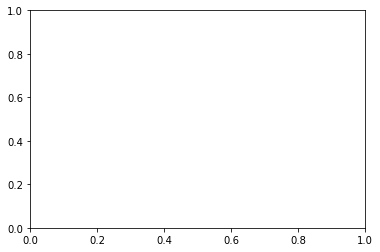

In [10]:
f1,axis1= plt.subplots()

y = (reached,cancelled)
index = np.array(['Reached','Cancelled'])
bar=axis1.bar(index,y,width=0.5,color='b')
axis1.set_title('Reached and cancelled targets')

> REMARK: In both "Barplot visualization" and "Histogram Visualization", for updating data, it is necessary to click upon the `run` button for running the jupyter nootebook cell (alternatively, press `ctrl` + `enter`)

## Histogram visualization

The histogram representation is here exploited for visualizing the time employed by the robot to reach a goal. Moreover, ```start_time``` and ```stop_time``` are variables used to generate a timer useful for computing the length of each bar. To conclude with, inside the clbk of ```/go_to_point/result``` a data.append is performed, in order to continuously update the histogram, as new targets are reached.

NameError: name 'data' is not defined

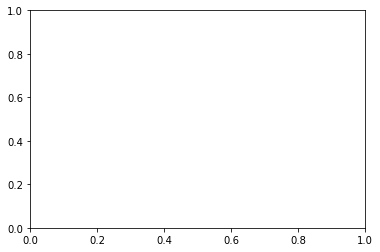

In [11]:
f2,axis2=plt.subplots()

X=list(range(0,len(data),1))
bar2=axis2.bar(X,data,width=0.5,color='r')
axis2.set_title('Mean time to reach a target')

## Line plots and animator

For visualizing changes in data, the ```animation.FuncAnimation``` method, has been employed. Both angular and linear velocities are represented as changing lines. They are function of time, indeed their magnitude is equal to the robot current velocity.

## Linear Velocity

In the  figure below, it is possible to monitor the **linear velocity** subscribed by ```/odom```and``` /cmd_vel```. 

In [12]:
def init1():
    line1.set_data([], [])
    line2.set_data([], [])
    return [line1,line2]

    

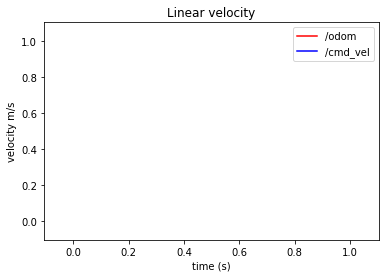

In [13]:
fig1, ax1 = plt.subplots()



line1, = ax1.plot([], [], color ='r', label ='/odom')
line2, = ax1.plot([], [], color ='b', label ='/cmd_vel')
ax1.set_xlabel('time (s)') 
ax1.set_ylabel('velocity m/s')
ax1.set_title("Linear velocity")
plt.legend(loc='upper right')

In [14]:
def animate1(i):
    # line values refresh
    line1.set_data(time_plot, odom_linear)
    line2.set_data(time_plot, cmdvel_linear)
    ax1.axis([time_plot[0]-0.2,time_plot[9]+0.2,-0.5,0.5])    
    # x axis updating...
    return [line1,line2]

# animator
anim1 = animation.FuncAnimation(fig1, animate1, init_func=init1,
                               frames=100, interval=20, blit=True)

## Angular Velocity

In the  figure below, it is possible to monitor the **angular velocity** subscribed by ```/odom```and``` /cmd_vel```. 
> The same line of conduct used for the aforementioned linear velocity is here now adopted 

In [15]:
def init2():
    line3.set_data([], [])
    line4.set_data([], [])
    return [line3,line4]


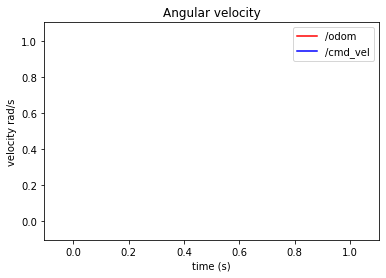

In [16]:
fig2, ax2 = plt.subplots()



line3, = ax2.plot([], [], color ='r', label ='/odom')
line4, = ax2.plot([], [], color ='b', label ='/cmd_vel')
ax2.set_xlabel('time (s)') 
ax2.set_ylabel('velocity rad/s')
ax2.set_title("Angular velocity")
plt.legend(loc='upper right')

In [17]:

def animate2(i):
    line3.set_data(time_plot, odom_angular)
    line4.set_data(time_plot, cmdvel_angular)
    ax2.axis([time_plot[0]-0.2,time_plot[9]+0.2,-0.5,0.5])
    return [line3,line4]

anim2 = animation.FuncAnimation(fig2, animate2, init_func=init2,
                               frames=100, interval=20, blit=True)

## Show Position

In the figure below, I iterated the same method as before, showing the position of the robot inside the environment. The values are retrieved from the ```odometry``` callback  and then they have been shown on (x,y) plane.

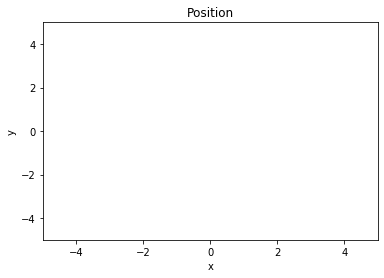

In [18]:
fig, ax = plt.subplots()

ax.set_xlim(( -5, 5))
ax.set_ylim((-5, 5))
ax.set_xlabel('x') 
ax.set_ylabel('y')
ax.set_title("Position")
line, = ax.plot([], [], 'ro')
    

In [19]:
def init():
    line.set_data([], [])
    return (line,)




In [15]:
def animate(i):
    line.set_data(x_data, y_data)
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)

## Show Orientation

To conclude with, the orientation of the robot could be visualized, by showing an arrow whose:
- tail is positioned where the robot is located (inside the virtual environment)
- orientation is the same of the robot

NameError: name 'dx' is not defined

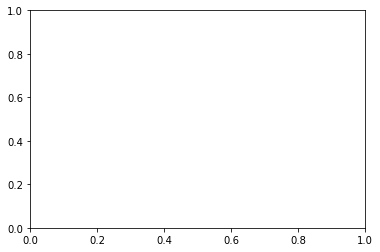

In [16]:
fig4, ax4 = plt.subplots()
ax.set_xlim((-5,5))
ax.set_ylim((-5,5))
# Using quiver method for displaying an arrow 
ax4.quiver(0,0,dx,dy,label='Orientation')
ax4.set_title("Orientation")
ax4.legend()
line4, = ax.plot([], [], color='b')

In [ ]:
def init4():
    global dx, dy
    ax4.quiver(0,0,dx,dy,label='Orientation')
    return (line4,)

def animate4(i):
    global x_data, y_data, dx, dy
    ax4.clear()
    ax4.quiver(x_data[49],y_data[49],dx,dy,label='Orientation')
    ax4.legend()
    ax4.set_title("Orientation")
    return (line4,)

anim4=animation.FuncAnimation(fig4, animate4, init_func=init4, frames=1, interval=100, blit=True)